In [ ]:
#This notebook implements an SPSA search to load a given probability distribution
#into a parameterized quantum circuit.

In [11]:
from qiskit import QuantumCircuit, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
import numpy as np



In [4]:
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-08-13 12:07:54,727: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [80]:
def initialize(n):
    qc = QuantumCircuit(n, n)
    qc.h(range(n)) #uniform prior
    return qc

def add_rys(qc, theta, qubits):
    for k in range(len(qubits)):
        qc.ry(theta[k], qubits[k])
        
def entangle(qc, qubits):
    for k in range(len(qubits)-1):
        qc.cz(qubits[k], qubits[k+1])
    qc.cz(qubits[-1], qubits[0])
    
def alternate(qc, qubits, thetas, n_iter):
    for k in range(n_iter):
        entangle(qc, qubits)
        qc.barrier()
        add_rys(qc, thetas[k], qubits)
        

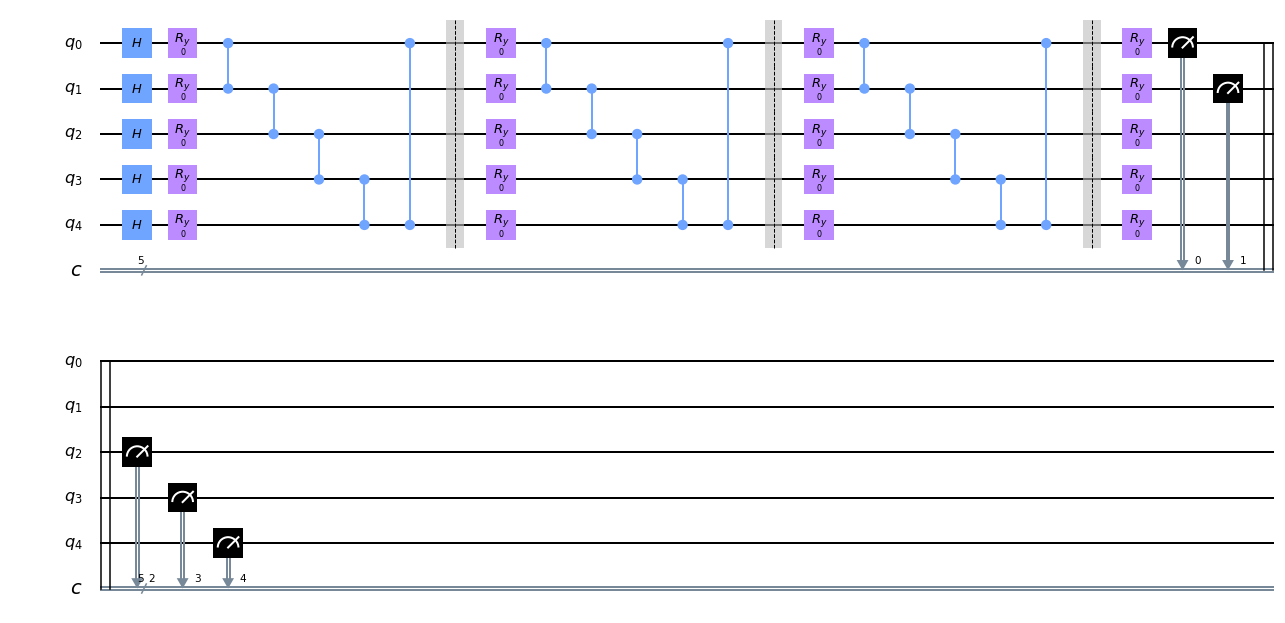

In [81]:
def make_circuit(n_qubits, repetitions, thetas):
    qc = initialize(n_qubits)
    add_rys(qc, thetas[0], range(n_qubits))
    alternate(qc, range(n_qubits), thetas[1:], repetitions)
    qc.measure(range(n_qubits), range(n_qubits))
    return qc


n_qubits = 5
n_reps = 3
init_theta = np.tile(np.zeros(n), (n_reps+1,1))
generator = make_circuit(n_qubits, n_reps, init_theta)
generator.draw('mpl')

In [168]:
def spsa_gradient(f):
    def grad(theta_n, c_n):
        delta_n = 2.0 * (np.random.binomial(1, 0.5, np.shape(theta_n)) - 0.5)
        theta_plus = theta_n + c_n * delta_n
        theta_minus = theta_n - c_n * delta_n
        
        f_plus = f(theta_plus)
        f_minus = f(theta_minus)
        
        f_min = None
        theta_min = None
        if f_plus < f_minus:
            f_min = f_plus
            theta_min = theta_plus
        else:
            f_min = f_minus
            theta_min = theta_minus
        return theta_min, f_min, (f_plus - f_minus)/(2.0 * c_n * delta_n)
    return grad

def spsa_iterate(a, c, num_iter, thetas, fvals, f, f_grad):
    for n in range(num_iter):
        theta_n = thetas[-1]
        E_n = fvals[-1]
        a_n = a/(n+1)
        c_n = c/np.sqrt(n+1)
        theta_min, f_min, g_n = f_grad(theta_n, c_n)
        #g_n = f_grad(theta_n, c_n)
        theta_n = theta_n - a_n * g_n
        E_n = f(theta_n)

        if E_n < f_min:
            #thetas = np.concatenate((thetas,[theta_n]))
            thetas.append(theta_n)
            fvals.append(E_n)
        else:
            #thetas = np.concatenate((thetas,[theta_min]))
            thetas.append(theta_min)
            fvals.append(f_min)
    return thetas, fvals

def spsa(a, c, n_iter_per_start, n_restarts, theta_0, fval_0, f, f_grad):
    thetas = [theta_0]
    fvals = [fval_0]
    for k in range(n_restarts+1):
        thetas, fvals = spsa_iterate(a, c, n_iter_per_start, thetas, fvals, f, f_grad)
    return thetas, fvals



In [153]:
def entropy(p,q):
    return -np.sum(p*np.log(q))

def qc_entropy(dist, n_qubits, n_reps, backend, n_shots):
    def f(theta):
        qc = make_circuit(n_qubits, n_reps, theta)
        counts = execute(qc, backend, shots=n_shots).result().get_counts()
        q = np.zeros(2**n_qubits)
        for k,v in counts.items():
            q[int(k,2)] = v/n_shots
        return entropy(p,q) - entropy(p,p)
        
    return f

In [177]:
n_qubits = 3
n_reps = 2
n_sim = 8192

#target dist
dist = np.random.uniform(0,1,2**n_qubits)
dist /= sum(dist)

#setup hyper parameters
a = 1.5
c = 0.1


backend = BasicAer.get_backend('qasm_simulator')
loss = qc_entropy(dist, n_qubits, n_reps, backend, n_sim)
loss_grad = spsa_gradient(loss)

#initial guess
theta_0 = np.tile(np.pi/4*np.ones(n_qubits), (n_reps+1,1))
E_0 = loss(theta_0)

#run iteration
n_restarts = 1
n_iter_per_start = 100
thetas, energies = spsa(a, c, n_iter_per_start, n_restarts, theta_0, E_0, loss, loss_grad)

[0.23683868, 0.0831035, 0.068417, 0.28104935, 0.03880915, 0.02979544, 0.05880383, 0.20318305]


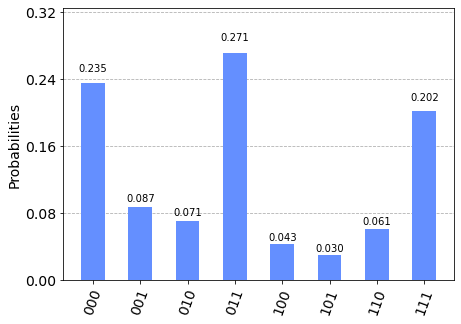

In [184]:
theta_est = np.mean(thetas[150:], axis=0)
#theta_est = thetas[-1]

qc = make_circuit(n_qubits, n_reps, theta_est)
counts = execute(qc, backend, shots=2**16).result().get_counts()
print(p)
plot_histogram(counts)

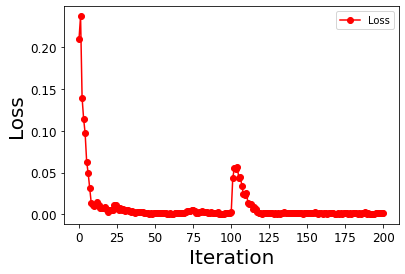

In [179]:
#plot energies
import matplotlib.pyplot as pyplot
pyplot.plot(range((n_restarts+1)*n_iter_per_start+1), energies, '.-r', markersize=12)
pyplot.legend(['Loss'])#, 'Avg energy level'])
pyplot.xlabel('Iteration', fontdict={'size':20})
pyplot.ylabel('Loss', fontdict={'size':20})
pyplot.tick_params(axis='x', labelsize=12)
pyplot.tick_params(axis='y', labelsize=12)
pyplot.show()

No handles with labels found to put in legend.


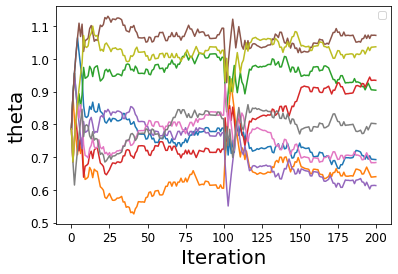

In [180]:
#plot thetas
n = len(thetas[0])
for k in range(n):
    for j in range(len(thetas[0][k])):
        pyplot.plot(range((n_restarts+1)*n_iter_per_start+1), [a[k][j] for a in thetas], markersize=12)
#pyplot.plot(range(num_iter+1), [a[1] for a in thetas], '.-b', markersize=12)
#pyplot.ylim([-1.4, -1.3])
pyplot.legend()#['theta_0', 'theta_1'])#, 'Avg energy level'])
pyplot.xlabel('Iteration', fontdict={'size':20})
pyplot.ylabel('theta', fontdict={'size':20})
pyplot.tick_params(axis='x', labelsize=12)
pyplot.tick_params(axis='y', labelsize=12)
pyplot.show()

In [140]:
thetas[-1]

array([[0.75502479, 0.72220682, 1.02654998],
       [0.75502479, 0.72220682, 1.02654998],
       [0.75502479, 0.72220682, 1.02654998]])